<a href="https://colab.research.google.com/github/alomrani/Self-Driving-car-speed/blob/master/speedchallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import collections
import pickle
from tqdm import tqdm
import pylab
use_colab = True
if use_colab:
  from google.colab import drive
import tensorflow as tf
TINY = 1e-30
EPS = 1e-4
nax = np.newaxis
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import random
import cv2
import csv
from skimage import color
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_, constant_
# from .util import conv, predict_flow, deconv, crop_like
# Hyper-parameters 
input_size = 4096   # 784
num_classes = 10
num_epochs = 35
batch_size = 100
learning_rate = 0.1
momentum = 0.8
if use_colab:
  drive_name = '/content/drive'
  drive.mount(drive_name)
  drive_413_A1_folder = 'comma_ai_speedchallenge'
  drive_location = drive_name + '/My Drive/' + drive_413_A1_folder  # Change this to where your files are located
else:
  # set the drive_location variable to whereever the extracted contents are.
  drive_location = ''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

try:
    from spatial_correlation_sampler import spatial_correlation_sample
except ImportError as e:
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("default", category=ImportWarning)
        warnings.warn("failed to load custom correlation module"
                      "which is needed for FlowNetC", ImportWarning)


def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )


def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)


def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )


def correlate(input1, input2):
    out_corr = spatial_correlation_sample(input1,
                                          input2,
                                          kernel_size=1,
                                          patch_size=21,
                                          stride=1,
                                          padding=0,
                                          dilation_patch=2)
    # collate dimensions 1 and 2 in order to be treated as a
    # regular 4D tensor
    b, ph, pw, h, w = out_corr.size()
    out_corr = out_corr.view(b, ph * pw, h, w)/input1.size(1)
    return F.leaky_relu_(out_corr, 0.1)


def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  # This is added back by InteractiveShellApp.init_path()


In [0]:
import os
import numpy as np
import shutil
import torch


def save_checkpoint(state, is_best, save_path, filename='checkpoint.pth.tar'):
    torch.save(state, os.path.join(save_path,filename))
    if is_best:
        shutil.copyfile(os.path.join(save_path,filename), os.path.join(save_path,'model_best.pth.tar'))


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return '{:.3f} ({:.3f})'.format(self.val, self.avg)


def flow2rgb(flow_map, max_value):
    flow_map_np = flow_map.detach().cpu().numpy()
    _, h, w = flow_map_np.shape
    flow_map_np[:,(flow_map_np[0] == 0) & (flow_map_np[1] == 0)] = float('nan')
    rgb_map = np.ones((3,h,w)).astype(np.float32)
    if max_value is not None:
        normalized_flow_map = flow_map_np / max_value
    else:
        normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    rgb_map[0] += normalized_flow_map[0]
    rgb_map[1] -= 0.5*(normalized_flow_map[0] + normalized_flow_map[1])
    rgb_map[2] += normalized_flow_map[1]
    return rgb_map.clip(0,1)

In [0]:
def exctract_frames():
  cap = cv2.VideoCapture("speedchallenge/data/train.mp4")

  i = 0
  # with open(drive_location + "/speedchallenge/data/dataX.csv", "a") as f:
    # writer = csv.writer(f)
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # print(1)
      # writer.writerow(frame.flatten())
      cv2.imwrite('speedchallenge/data/trainFrames/'+str(i)+'.jpg',frame)
      i+=1

  cap.release()
  cv2.destroyAllWindows()

In [0]:
train_speed = []
f = open("speedchallenge/data/train.txt", "r")
for s in f:
  train_speed.append(float(s.strip()))

In [0]:
def dataset_constructor(train_speed):
    meta_dict = {}
    for idx, speed in enumerate(train_speed):
        img_path = 'speedchallenge/data/trainFrames/'+str(idx)+'.jpg'
        meta_dict[idx] = [img_path, idx, speed]
    meta_df = pd.DataFrame.from_dict(meta_dict, orient='index')
    meta_df.columns = ['image_path', 'image_index', 'speed']
    meta_df.to_csv('speedchallenge/data/train_meta.csv', index=False)

In [0]:
# def pre_proccess(frame):
#   frame = frame[:,80:370,:]
#   frame = cv2.resize(frame, (220, 66), interpolation = cv2.INTER_AREA)
#   return frame

In [0]:
dataset_constructor(train_speed)

In [0]:
train_meta = pd.read_csv('speedchallenge/data/train_meta.csv')
train_meta.head()

,image_path,image_index,speed
0,speedchallenge/data/trainFrames/0.jpg,0,28.105569
1,speedchallenge/data/trainFrames/1.jpg,1,28.105569
2,speedchallenge/data/trainFrames/2.jpg,2,28.106527
3,speedchallenge/data/trainFrames/3.jpg,3,28.130404
4,speedchallenge/data/trainFrames/4.jpg,4,28.109243


In [0]:
def train_valid_split(dframe):
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(dframe) - 1):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
         
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [0]:
train_data, val_data = train_valid_split(train_meta)

In [0]:
import torchvision.transforms as transforms
from imageio import imread, imwrite
class ArrayToTensor(object):
    """Converts a numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)."""

    def __call__(self, array):
        assert(isinstance(array, np.ndarray))
        array = np.transpose(array, (2, 0, 1))
        # handle numpy array
        tensor = torch.from_numpy(array)
        # put it from HWC to CHW format
        return tensor.float()

input_transform = transforms.Compose([
        ArrayToTensor(),
        transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
        transforms.Normalize(mean=[0.411,0.432,0.45], std=[1,1,1])
    ])

In [0]:
def preprocess_image_from_path(image_path, speed):
    img = input_transform(cv2.imread(image_path))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:,80:370,:]
    return img, speed

In [0]:
from sklearn.utils import shuffle
def generate_training_data(data, model,batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0]
                                                )
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0]
                                                )
           
            a = torch.cat([x1,x2]).unsqueeze(0)
            img_diff = model(a)
            # img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            img_diff = F.interpolate(img_diff, size=[66, 220], mode='nearest').squeeze(0)
            rgb_flow = flow2rgb(20 * img_diff, max_value=10)
            opticalflow = (rgb_flow * 255).astype(np.uint8).transpose(1,2,0)
            # compute optical flow send in images as RGB
            # plt.imshow(opticalflow)
            # plt.show()
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = opticalflow
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [0]:
def generate_validation_data(data, model):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            a = torch.cat([x1,x2]).unsqueeze(0)
            img_diff = model(a)
            # img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            img_diff = F.interpolate(img_diff, size=[66, 220], mode='nearest').squeeze(0)
            rgb_flow = flow2rgb(20 * img_diff, max_value=10)
            opticalflow = torch.tensor((rgb_flow * 255).astype(np.uint8)).unsqueeze(0).view(1, 66, 220, 3)

            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            # print('img_diff', opticalflow.shape, ' speed', speed)
            yield opticalflow, speed

In [0]:
model_weights = torch.load(drive_location+"/speedchallenge/data/flownets_bn_EPE2.459.pth.tar")

In [0]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_, constant_
# from .util import conv, predict_flow, deconv, crop_like

__all__ = [
    'flownets', 'flownets_bn'
]


class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=True):
        super(FlowNetS,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]


def flownets(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)
    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=False)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model


def flownets_bn(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)
    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=True)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

In [0]:
model = flownets_bn(model_weights).eval()

torch.Size([2, 66, 220])


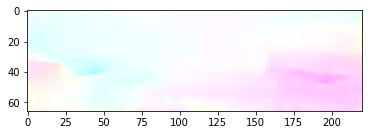

In [0]:
framelocation = "speedchallenge/data/trainFrames/503.jpg"
testframe = input_transform(cv2.imread(framelocation))
testframe = testframe[:,80:370,:]
framelocation1 = 'speedchallenge/data/trainFrames/504.jpg'
testframe1 = input_transform(cv2.imread(framelocation1))
testframe1 = testframe1[:,80:370,:]
a = torch.cat([testframe,testframe1]).unsqueeze(0)
model = model.eval()
# a = a.view(a.shape[-1],a.shape[0],a.shape[1]).unsqueeze(0)
opticalflow = model(a)
output = F.interpolate(opticalflow, size=[66, 220], mode='nearest').squeeze(0)
print(output.shape)
rgb_flow = flow2rgb(20 * output, max_value=10)
to_save = (rgb_flow * 255).astype(np.uint8).transpose(1,2,0)
plt.imshow(to_save)
plt.show()

In [0]:
from keras.models import Sequential
N_img_height = 66
N_img_width = 220
N_img_channels = 3

def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [0]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
val_size = len(val_data.index)
valid_generator = generate_validation_data(val_data, model)
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(drive_location+ "/speedchallenge/weights.h5", 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

# tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
#                             write_graph=True, write_images=True)

callbacks_list = [earlyStopping, modelCheckpoint]

In [0]:
model1 = nvidia_model()

In [0]:
num_epochs = 25 #100 #90 
steps_per_epoch = 2
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, model, 16)
history = model1.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

Epoch 1/25
1/2 [==============>...............] - ETA: 8s - loss: 6.2143

KeyboardInterrupt: ignored

In [0]:
!cp -r /content/drive/My\ Drive/comma_ai_speedchallenge/speedchallenge /content/

In [0]:
model1.predict(torch.tensor(to_save).unsqueeze(0))

array([[21.310968]], dtype=float32)

In [0]:
val_data.iloc(0)[13]

index                                              503
image_path     speedchallenge/data/trainFrames/503.jpg
image_index                                        503
speed                                          16.5201
Name: 0, dtype: object

In [0]:
model1.save(drive_location+"/speedchallenge/data/model.h5")

array([[21.310968]], dtype=float32)